# Deepy
*Deep Learning from matrix multiplications*  
Jerome van der Elst, Simon Janssen, Christoph Tietz  
**EPFL Course EE-559 Deep Learning, Spring 2020 Lausanne**

In [1]:
#!/usr/bin/env python
import math
import sys
import logging
logging.basicConfig(level=logging.WARNING)

try:
    import torch
    torch.set_grad_enabled(False)
    SEED = 2
    torch.manual_seed(SEED)
except ImportError as e:
    sys.exit("ERROR: please install pytorch requirement")

In [2]:
class Loss():
    def loss(self, p, t):
        """
        loss function
         :param v: predicted values
                t: known target values, what answer should be
         :return: derivative of loss function with respect to predicted values
         """
        raise NotImplementedError

    def dloss(self, p, t):
        """
        :param v: predicted values
               t: known target values, what answer should be
        :return: derivative of loss function with respect to predicted values
        """
        raise NotImplementedError


class lossMSE(Loss):
    def loss(self, p, t):
        return (p - t).pow(2).sum()

    def dloss(self, p, t):
        return 2 * (p - t)

In [3]:
def split(inputs: torch, targets, trp, vp):
    """
    split data into training, validation and test set
    Should be used in the following way:
                for each epoch
                for each training data instance
                    propagate error through the network
                    adjust the weights
                    calculate the accuracy over training data
                for each validation data instance
                    calculate the accuracy over the validation data
                if the threshold validation accuracy is met
                    exit training
                else
                    continue training
                Finally: get independent accuracy result with test set
    :param input: input data
           label: labels of input data
           trp: train percentage
           vp: validation percentage
           tp: test percentage, calculated as 1-trp-vp
    :return  tr_inputs: training inputs
             tr_targets: training targets
             v_inputs: validation inputs
             v_targets: validation targets
             t_inputs: test inputs
             t_targets: test targets
    """
    tr_len = math.floor(inputs.size()[0] * trp)
    v_len = math.floor(inputs.size()[0] * vp)
    t_len = inputs.size()[0] - tr_len - v_len

    tr_inputs = inputs.narrow(dim=0, start=0, length=tr_len)
    tr_targets = targets.narrow(dim=0, start=0, length=tr_len)

    v_inputs = inputs.narrow(dim=0, start=0, length=v_len)
    v_targets = targets.narrow(dim=0, start=0, length=v_len)

    t_inputs = inputs.narrow(dim=0, start=0, length=t_len)
    t_targets = targets.narrow(dim=0, start=0, length=t_len)

    return tr_inputs, tr_targets, v_inputs, v_targets, t_inputs, t_targets


def predict(model, inputs):
    """
    Prediction with model. Input should be compatible with model!
    :param model: trained model to be used for prediction
           inputs: data for which model should predict label
                   ---> size = (#inputs, size of  input layer of model)
    :return: prediction of the model on specified inputs
             ---> size = (#inputs, size of output layer of model)
    """
    res = torch.zeros(inputs.size())
    for index, input in enumerate(inputs):
        o = model.forward(input)
        res[index] = o
    return res

def train(model, tr_i, tr_t, learning_rate, epochs, v_i=None, v_t=None,  callBack=None, loss=lossMSE):
    """
    :params model: to be trained
            tr_i: training dataset inputs
                  --> dimensions compatible with network input dimension
            tr_t: training dataset targets
                  --> dimensions compatible with network output dimension
            lr: learning rate
            epochs: number of training loops
            v_i: validation set input
            v_t: validation set target
            callBack = callback(input, target) function to calculate the error rate
    :return: the trained model
    """
    print("Training model: {0}".format(model.name))
    sgd = SGD(model.param(), learning_rate=learning_rate)
    n = tr_i.size(0)
    tr_errors=[]
    v_errors=[]
    for epoch in range(epochs):
        for i in range(n):
            sgd.zero_grad()
            model_output = model.forward(tr_i[i])
            dl_dYpred = loss().dloss(model_output, tr_t[i])
            model.backward(dl_dYpred)
            sgd.step()
        if callBack is not None:
            tr_error = callBack(predict(model, tr_i), tr_t)
            tr_errors.append(tr_error)
            v_error = callBack(predict(model, v_i), v_t)
            v_errors.append(v_error)
            print("Epoch {0:3} with training error = {1:4.2f}% with validation error = {2:4.2f}%".format(epoch+1, tr_error, v_error))
    return tr_errors, v_errors


In [4]:
class SGD():
    """"  """

    def __init__(self, modulesParams, learning_rate):
        self.modulesParams = modulesParams
        self.learning_rate = learning_rate

    def step(self):
        """
        update params in direction of gradient according to learning rate
        learn the weights after a single tuple passes through network
        """
        for param in self.modulesParams:
            (weight, grad) = param
            # print("grad", grad)
            weight.add_(-self.learning_rate * grad)

    def zero_grad(self):
        """
         gradients are add_'ed at each step, should therefor be zero_'ed
         reset gradients to zero before sending the next tuple through the network
        """
        for param in self.modulesParams:
            (weight, grad) = param
            grad.zero_()

In [5]:
class Module(object):
    """
    Base class for NN modules
    """

    def __init__(self):
        pass

    def forward(self, *input):
        """
        This is the forward implementation of the NN
        :param input: ONE element of the dataset
        :return: tensor or a tuple of tensors
        """
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        """
        This is the backpropagation implemenation of the NN
        --> use chaine rule to compute dl_dInput from dl_dOutput
        :param gradwrtoutput: tensor or tuple of tensors (dl_dOutput_i)
        :return: tensor or a tuple of tensors (dl_dInput_i)
        """
        raise NotImplementedError

    def param(self):
        """
        :return: a list of pairs of tensors; (parameter, tensor) with parameter.size() = tensor.size()
                 Will be used to update weights as follows; w = w - learning_rate * grad
        """
        return []


class Sequential(Module):
    """
    Module appending subModules in sequential way
    """

    def __init__(self, *args):
        super().__init__()
        self.modules = list(args)
        self.name = "{0}".format(" -> ".join(map(lambda x: x.name, self.modules)))

    def forward(self, input):
        out = input
        for module in self.modules:
            out = module.forward(out)
        return out

    def backward(self, gradwrtoutput):
        """
        for backpropagation just apply 'backward method' sequentially for all submodules
        """
        out = gradwrtoutput
        for module in reversed(self.modules):
            out = module.backward(out)
        return out

    def param(self):
        parameters = []
        for module in self.modules:
            parameters += module.param()
        return parameters


class Linear(Module):
    """
    Module that calculates weighted sum plus bias of input
       --> for whole layer of neurons; multiple sums
    """

    def __init__(self, input_dim, output_dim, epsilon):
        super().__init__()
        self.name = "Linear({0})({1})".format(input_dim,output_dim)
        self.x = 0
        self.weight = torch.Tensor(output_dim, input_dim).normal_(mean=0, std=epsilon)
        self.bias = torch.Tensor(output_dim).normal_(0, epsilon)
        self.dl_dw = torch.Tensor(self.weight.size())
        self.dl_db = torch.Tensor(self.bias.size())

    def forward(self, input):
        self.x = input
        return self.weight.mv(self.x) + self.bias

    def backward(self, gradwrtoutput):
        """
        si = sum(w1i*x1 + ... + wni*xn) forall i
        s = [[w11,...,wn1], ..., [w1n,...,wnn]] @  [x1,...,xn]T
        gradwrtouput = dl_ds
        dl_dw = dl_ds * ds_dw = gradwrtoutput * x -> 2d matrix (i,j): dl_ds_i * dsi_dx_j
        dl_db = dl_ds * ds_db = gradwrtoutput
        dl_dx = dl_ds * ds_dx = gradwrtoutput * w
        """
        self.dl_dw.add_(gradwrtoutput.view(-1, 1).mm(self.x.view(1, -1)))
        self.dl_db.add_(gradwrtoutput)
        dl_dx = gradwrtoutput.unsqueeze(0).mm(self.weight).squeeze(0)
        return dl_dx

    def param(self):
        return [(self.weight, self.dl_dw), (self.bias, self.dl_db)]


class Tanh(Module):
    """
    Module that calculates Tanh
    """

    def __init__(self):
        super().__init__()
        self.name = "Tanh"
        self.s = 0

    def forward(self, input):
        self.s = input
        return torch.tanh(input)

    def backward(self, gradwrtoutput):
        """
        s --tanh()--> x; activation function sigma = tanh
        dl_dx = gradwrtoutput
        dx_ds = sigma'(s); x = sigma(s)
        dl_ds = dl_dx * dx_ds
        """
        return gradwrtoutput * (1 - torch.tanh(self.s).pow(2))

    def param(self):
        return []


class ReLu(Module):
    """
    Modules that calculates ReLu
    """

    def __init__(self):
        super().__init__()
        self.name="ReLu"
        self.s = 0

    def forward(self, input):
        self.s = input
        return input.clamp(min=0)

    def backward(self, gradwrtoutput):
        """
        s --relu()--> x, activation function sigma = relu
        dl_dx = gradwrtoutput
        dx_ds = sigma'(s) because x = sigma(s)
        dl_ds = dl_dx * dx_ds
        """
        dx_ds = self.s.sign().clamp(min=0)
        return gradwrtoutput * dx_ds

    def param(self):
        return []


class LeakyReLu(Module):
    """
    Modules that calculates LeakyReLu = 0.1x if negative and x if positive
    """

    def __init__(self):
        super().__init__()
        self.name="LeakyReLu"
        self.s = 0

    def forward(self, input):
        self.s = input
        return input.clamp(min=0).add(input.clamp(max=0) * 0.1)

    def backward(self, gradwrtoutput):
        """
        s --relu()--> x, activation function sigma = relu
        dl_dx = gradwrtoutput
        dx_ds = sigma'(s) because x = sigma(s)
        dl_ds = dl_dx * dx_ds
        """
        dx_ds = self.s.sign().clamp(min=0).add(self.s.sign().clamp(max=0) * -0.1)
        return gradwrtoutput * dx_ds

    def param(self):
        return []

## Testing

In [8]:
#!/usr/bin/env python
import argparse
import math
import sys



def create_disc(n=1000):
    """
    Creates data points tensor uniformly sampled in range [0,1]
    labels are +1 for points inside circle centered in (0.5,0.5) with radius 1/sqrt(2pi)
    labels are 0 for points outside circle
    :param: n: number of sampled points
    :return samplePoints: sampled points
            labels: labels of sampled points
    """
    samplePoints = torch.rand(n, 2)
    centered = samplePoints - torch.Tensor([[0.5, 0.5]])
    distances = torch.norm(input=centered.abs(), p=2, dim=1, keepdim=True)
    radius = 1 / math.sqrt(2 * math.pi)
    labels = (distances - radius).sign().mul(-1).add(1).div(2)
    return samplePoints, labels


def draw_circle(samplePoints, labels, title, axis):
    """
    Visualization of the labelled data
    :param samplePoints: 2d locations
           labels: labels elem {0,1}
           title: string to put as title on plot
           axis: axis object on which to draw
    :return:
    """
    mask1 = torch.flatten(labels) == 1
    mask0 = torch.flatten(labels) == 0
    inn = samplePoints[mask1, :]
    out = samplePoints[mask0, :]
    axis.scatter(inn[:, 0], inn[:, 1], c='r', s=1)
    axis.scatter(out[:, 0], out[:, 1], c='b', s=1)
    axis.set_title(title)
    return axis


def binaryToOneHot(t_b):
    """
    :param t_b: 1-dimensional tensor of 0's and 1's
    :return: - 1-dimensional tensor of size 2 if t_b was of size 1
             - 2-dimensional tensor of where first column is one hot encoding for 0
               and second column is one hote encoding for 1
    :example: [0] ---> [1,0]
              [0,1,0] --> [[1,0],[0,1],[1,0]]
    """
    if (t_b.dim() == 1):
        res = torch.Tensor(2)
        res[0] = t_b[0] == 0
        res[1] = t_b[0] == 1
    else:
        res = torch.Tensor(t_b.size(0), 2)
        res[:, 0] = t_b.flatten() == 0
        res[:, 1] = t_b.flatten() == 1
    return res


def oneHotToBinary(t_o):
    """
    :param t_o: - 1-dimensional tensor of length 2
                - 2-dimensional tensor Nx2
                    column1: binary boolean for label O
                    column2: binary boolean for label 1
    :return:    - tensor of length 1
                - tensoor of length N
    :example: [1,0.5b ---> [1]
              [[0.5,0],[0.5,1],[1,1]] --> [0,1,0]
    """
    if (t_o.dim() == 1):
        res = (t_o[0] < t_o[1]).int()
    else:
        res = (t_o[:, 0] < t_o[:, 1]).int()
    return res

def errorP(predict, target):
    """
    :param predict: 1-dimensional prediction tensor
           target: 1-dimensional reference tensor
    :return percentage of differences
    """
    assert predict.size() == target.size()
    mask = (predict - target).abs()!=0
    return sum(mask).item() / predict.size(0) * 100



Training model: Linear(2)(25) -> ReLu -> Linear(25)(25) -> ReLu -> Linear(25)(25) -> Tanh -> Linear(25)(2) -> Tanh
Epoch   1 with training error = 34.30% with validation error = 34.50%
Epoch   2 with training error = 27.15% with validation error = 28.00%
Epoch   3 with training error = 24.70% with validation error = 24.50%
Epoch   4 with training error = 24.35% with validation error = 22.00%
Epoch   5 with training error = 23.10% with validation error = 21.00%
Epoch   6 with training error = 22.50% with validation error = 21.50%
Epoch   7 with training error = 18.25% with validation error = 17.00%
Epoch   8 with training error = 9.60% with validation error = 11.00%
Epoch   9 with training error = 8.70% with validation error = 7.50%
Epoch  10 with training error = 8.05% with validation error = 9.00%
Epoch  11 with training error = 9.80% with validation error = 9.50%
Epoch  12 with training error = 8.65% with validation error = 9.00%
Epoch  13 with training error = 7.65% with validation 

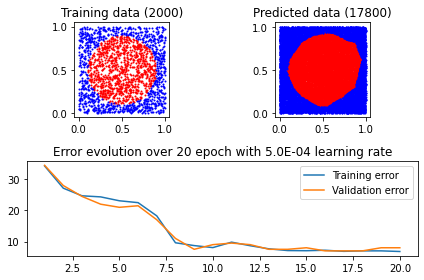

In [10]:
model = Sequential(
    Linear(input_dim=2, output_dim=25, epsilon=1),
    ReLu(),
    Linear(input_dim=25, output_dim=25, epsilon=1),
    ReLu(),
    Linear(input_dim=25, output_dim=25, epsilon=1),
    Tanh(),
    Linear(input_dim=25, output_dim=2, epsilon=1),
    Tanh()
)


LEARNING_RATE = 0.0005
EPOCHS = 20

inputs, targets = create_disc(20000)
tr_i, tr_t, v_i, v_t, t_i, t_t = split(inputs, targets, trp=0.1, vp=0.01)
calc_error = lambda p,t: errorP(oneHotToBinary(p),oneHotToBinary(t))
tr_error,v_error = train(model, tr_i, binaryToOneHot(tr_t), LEARNING_RATE, EPOCHS, v_i, binaryToOneHot(v_t), calc_error)
t_t_pred = oneHotToBinary(predict(model, t_i))
t_t_pred_error = errorP(t_t_pred, t_t.flatten())
print("Final Error Rate on independent Test Set = {0:4.2f}%".format(t_t_pred_error))


try:
    from matplotlib import pyplot as plt
    fig = plt.figure()
    ax1 = fig.add_subplot(221, aspect='equal')
    draw_circle(tr_i, tr_t, "Training data ({0})".format(tr_i.size(0)), ax1)
    ax2 = fig.add_subplot(222, aspect='equal')
    draw_circle(t_i, t_t_pred, "Predicted data ({0})".format(t_i.size(0)), ax2)
    ax3 = fig.add_subplot(212)
    ax3.plot(range(1,len(tr_error)+1),tr_error, label="Training error")
    ax3.plot(range(1,len(v_error)+1),v_error, label="Validation error")
    ax3.set_title("Error evolution over {0} epoch with {1:2.1E} learning rate".format(EPOCHS, LEARNING_RATE))
    ax3.legend()
    plt.tight_layout()
    plt.show()
except ImportError as e:
    sys.exit("WARNING: please install matplotlib for full experience")

